# Problem 1

Empirical validation of double descent. Start with some imports.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import Tensor
from torch.optim import SGD, AdamW
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

device = "cpu"

### Create data

No need to change this block.

In [3]:
# N samples with D inputs and O outputs
N = 100
D = 8
O = 8

# Training data
x = torch.randn(N, D)
noiselevel = 0.3
y = (1-noiselevel)*x + noiselevel*torch.randn(N, O)

# Test data
N_test = 1000
x_test = torch.randn(N_test, D)
y_test = (1-noiselevel)*x_test + noiselevel*torch.randn(N_test, O)

### Create model

In [4]:
class regression(nn.Module):
    def __init__(self, m: int, d_in: int, d_out: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(d_in, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, d_out),
        )

    def forward(self, X):
        return self.layers(X)

### Train model and validate double descent

In [5]:
def train(model, optimizer, criterion, loader_train):
    list_loss = []

    model.train()
    for Xtrain, ytrain in loader_train:
        optimizer.zero_grad()

        out = model(Xtrain)
        loss = criterion(ytrain, out)
        loss.backward()
        optimizer.step()

        list_loss.append(loss.detach().cpu().item())

    return list_loss

def test(model, criterion, xtest, ytest):
    model.eval()

    with torch.no_grad():
        out = model(xtest)
        loss = criterion(ytest, out)

    return loss.detach().cpu().item()

#### Problem 1.b.

In [6]:
#Implement here the rest of (b) and (c)
x_test, y_test = x_test.to(device), y_test.to(device)

def trigger_train(
    xtrain: Tensor,
    ytrain: Tensor,
    xtest: Tensor,
    ytest: Tensor,
    values_M: list,
    batch_size: int,
    lr: float=1e-3,
    num_epchs: int = 1000,
    device: str = "cpu"
):
    losses_train = {m: [] for m in values_M}
    losses_val = {m: [] for m in values_M}

    loader_train = DataLoader(
        TensorDataset(xtrain.to(device), ytrain.to(device)),
        batch_size=batch_size,
        shuffle=True
    )

    for M in tqdm(values_M):
        model = regression(M, d_in=D, d_out=O).to(device)
        optimizer = AdamW(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for _ in range(num_epchs):
            list_loss_train = train(model, optimizer, criterion, loader_train)
            losses_train[M].extend(list_loss_train)

            losses_val[M].append(test(model, criterion, xtest, ytest))

    return losses_train, losses_val

  0%|          | 0/3 [00:00<?, ?it/s]

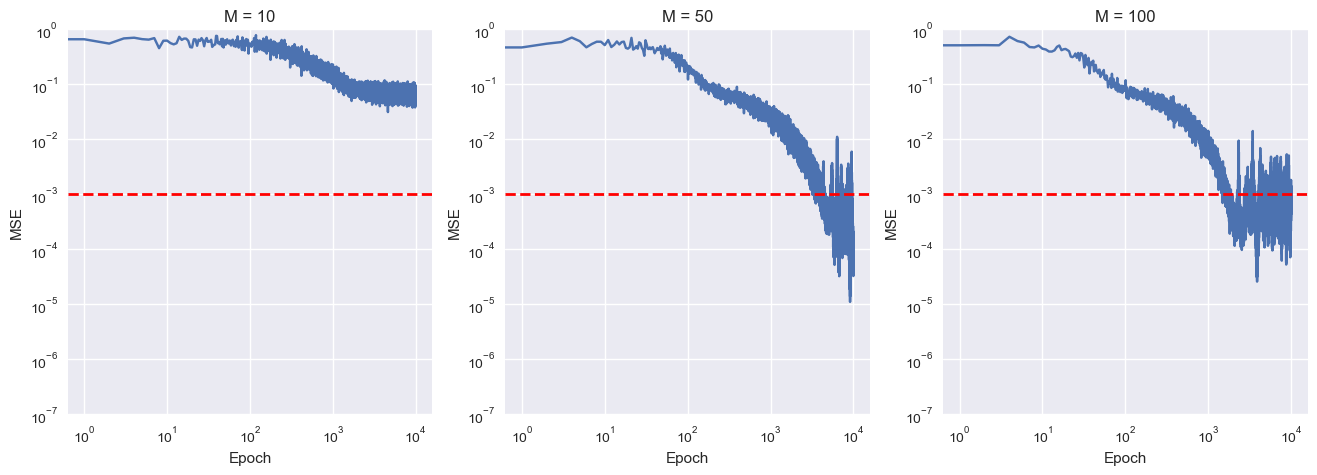

In [7]:
LR = 1e-3
NUM_EPCHS = 1000
batch_size = 10
values_M = [10, 50, 100]

losses_train, _ = trigger_train(x, y, x_test, y_test, values_M, batch_size, LR, NUM_EPCHS, device)

#Plotting hints for (b)
fig = plt.figure(figsize=(16, 5))

for idx, M in enumerate(values_M):

    ax = fig.add_subplot(1, 3, idx + 1)

    ax.plot(losses_train[M])

    ax.set_ylim([10**(-7),1])
    ax.axhline(y=1e-3, color='r', linestyle='--', linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.set_title(f"M = {M}")

#### Problem 1.c.

In [8]:
batch_size = N
LR = 5e-3
NUM_EPCHS = 1000
values_M = range(10, 200, 10)

losses_train, losses_val = trigger_train(x, y, x_test, y_test, values_M, batch_size, LR, NUM_EPCHS, device)

losses = []

for k, loss in losses_train.items():
    losses.append({
        'M': k,
        'mse': loss[-1],
        'loss_type': 'train'
    })

for k, loss in losses_val.items():
    losses.append({
        'M': k,
        'mse': loss[-1],
        'loss_type': 'val'
    })

df_loss = pd.DataFrame.from_records(losses)
df_loss.head()

  0%|          | 0/19 [00:00<?, ?it/s]

,M,mse,loss_type
0,10,0.061325,train
1,20,0.014811,train
2,30,0.000449,train
3,40,0.000067,train
4,50,0.000069,train


Text(0.5, 0, 'Number of neurons')

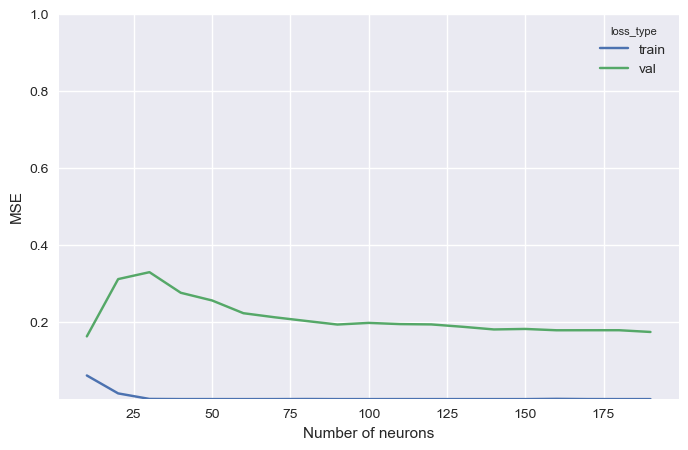

In [9]:
#Plotting hints for (c)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.lineplot(data=df_loss, x='M', y='mse', hue='loss_type')

ax.set_ylim([10**(-3),1])
ax.set_ylabel("MSE")
ax.set_xlabel("Number of neurons")

In [10]:
df_loss_val = df_loss[df_loss['loss_type'] == 'val']
interpolation_thres = df_loss_val[df_loss_val['mse'] == df_loss_val['mse'].max()]['M'].item()

print(f"Interpolation threshold: {interpolation_thres}")

Interpolation threshold: 30


### Having more data can hurt

Just repeat the same experiment with more data for two manually chosen K.

In [11]:
N = 200
x = torch.randn(N, D)
y = (1-noiselevel)*x + noiselevel*torch.randn(N, O)

#Implement here (d) 
M_interpol = interpolation_thres
M_overparam = 180
values_M = [M_interpol, M_overparam]

batch_size = N

_, losses_val = trigger_train(x, y, x_test, y_test, values_M, batch_size, LR, NUM_EPCHS, device)

  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
losses = []

for k, loss in losses_val.items():
    losses.append({
        'M': k,
        'mse': loss[-1],
    })

df_loss_2 = pd.DataFrame.from_records(losses)
df_loss_2['data'] = 'more'

df_tmp = df_loss[(df_loss['M'].isin(values_M)) & (df_loss['loss_type'] == 'val')]\
    .copy()\
    .drop(columns=['loss_type'])
df_tmp['data'] = 'less'

df_final = pd.concat([df_tmp, df_loss_2])


<Axes: xlabel='M', ylabel='mse'>

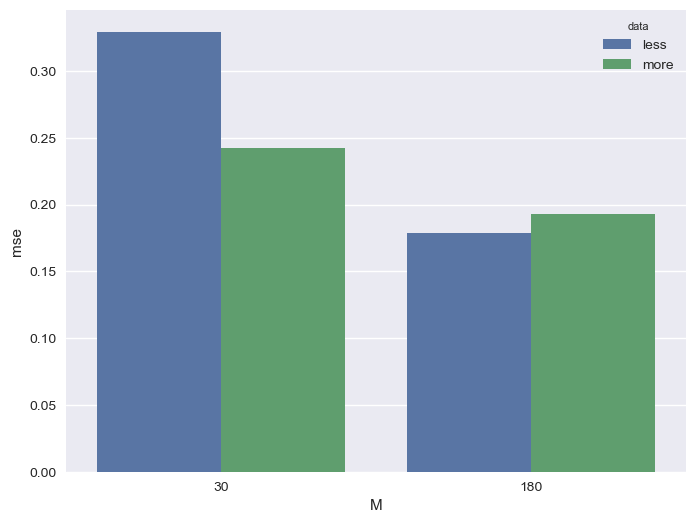

In [13]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
sns.barplot(data=df_final, x='M', y='mse', hue='data')

# Problem 2

Implicit regularization of SGD.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from matplotlib.ticker import FormatStrFormatter
from torch import nn
from torch import Tensor
from torch.optim import SGD, AdamW
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange
from tqdm.contrib.itertools import product

In [15]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

device = "cpu"

### Create data

In [16]:
# The same as in the first problem, but a bit more data
N = 200
D = 8
O = 8

# Training data
x = torch.randn(N, D)
noiselevel = 0.3
y = (1-noiselevel)*x + noiselevel*torch.randn(N, O)

# Test data
N_test = 1000
x_test = torch.randn(N_test, D)
y_test = (1-noiselevel)*x_test + noiselevel*torch.randn(N_test, O)

#
# ALTERNATIVE DATA SET
#
# The first release of the problem set used this data, but it may lead to less clear conclusions
# You can use also this data, especially if you started working on the problems before the exercise was changed, but mention it
# in your solution.
#N = 200
#x = torch.rand(N,3)*2. - 1.
#y = ((0.4*torch.sin(x[:,0])*x[:,1]**2. - 0.7*x[:,2]**3.)* torch.exp(-torch.sum(x**2.,1)/15.)).resize(N,1)
# Add some noise
#dist = torch.distributions.StudentT(4, 0, 1)
#y = y + 0.05*dist.rsample(torch.Size([N,1]))

# Test samples
#M = 10000
#xtest = torch.rand(M,3)*2. - 1.
#ytest = ((0.4*torch.sin(xtest[:,0])*xtest[:,1]**2. - 0.7*xtest[:,2]**3.)* torch.exp(-torch.sum(xtest**2.,1)/15.)).resize(M,1) + 0.05*dist.rsample(torch.Size([M,1]))

In [17]:
x, y = x.to(device), y.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

### Model

The same as in previous exercise.

In [18]:
class regression(nn.Module):
    def __init__(self, m: int, d_in: int, d_out: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(d_in, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, d_out),
        )

    def forward(self, X):
        return self.layers(X)

### Computing the required norms

In [19]:
def get_grad(model: nn.Module) -> Tensor:
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)

    return grads

def gradient_norms(model, objective, x, y, data_loader, lr):
    optimizer = SGD(model.parameters(), lr=lr)

    # Calculate gradient w.r.t full data
    optimizer.zero_grad()
    out = model(x)
    loss = objective(y, out)
    loss.backward()

    grads_full = get_grad(model) / x.shape[0]

    # Calculate gradient at each mini-batch
    total_grads_norm = 0
    n = 0
    for Xtrain, ytrain in data_loader:
        optimizer.zero_grad()
        out = model(Xtrain)
        loss = objective(ytrain, out)
        loss.backward()

        grads_minibatch = get_grad(model) / Xtrain.shape[0]
        total_grads_norm += torch.norm(grads_minibatch - grads_full)**2

        n += 1

    # Calculate the final
    grad_diff_norm = total_grads_norm / n
    grad_norm = torch.norm(grads_full) ** 2

    return grad_norm.item(), grad_diff_norm.item()

### Main loop

#### Problem 2.b.

In [20]:
num_epchs = 5000
batch_size = 20
M = 50
values_lr = [0.02, 0.04, 0.08, 0.16]
d_in, d_out = D, O

losses_train = {lr: [] for lr in values_lr}
losses_test = {lr: [] for lr in values_lr}
models = {lr: [] for lr in values_lr}


loader_train = DataLoader(
    TensorDataset(x.to(device), y.to(device)),
    batch_size=batch_size,
    shuffle=True
)

# Train model for each learning rate until convergent
for lr in values_lr:
    model = regression(M, d_in=d_in, d_out=d_out).to(device)
    optimizer = SGD(model.parameters(), lr=lr)
    
    criterion = nn.MSELoss()

    for _ in trange(num_epchs, desc=f"lr = {lr:.2f}"):
        # Train
        model.train()
        for Xtrain, ytrain in loader_train:
            optimizer.zero_grad()

            out = model(Xtrain)
            loss = criterion(ytrain, out)
            loss.backward()
            optimizer.step()

        losses_train[lr].append(loss.item())

        # Test
        model.eval()

        with torch.no_grad():
            out = model(x_test)
            loss = criterion(y_test, out)

        losses_test[lr].append(loss.item())

    models[lr] = model

lr = 0.02:   0%|          | 0/5000 [00:00<?, ?it/s]

lr = 0.04:   0%|          | 0/5000 [00:00<?, ?it/s]

lr = 0.08:   0%|          | 0/5000 [00:00<?, ?it/s]

lr = 0.16:   0%|          | 0/5000 [00:00<?, ?it/s]

#### Problem 2.c.

In [21]:
grads_norm = []
grads_diff_norm = []

criterion = nn.MSELoss()
for lr in values_lr:
    grad_norm, grad_diff_norm = gradient_norms(models[lr], criterion, x, y, loader_train, lr)

    grads_norm.append(grad_norm)
    grads_diff_norm.append(grad_diff_norm)

#### Problem 2.d.

In [22]:
NUM_EPCHS = 1000
NUM_EPCHS_LOG = 10

values_batch_size = [10, 20]
values_M = [50, 120]
values_lr_d = [0.08, 0.16]
values_beta = [0.1, 0.01, 0.001]

losses = []

criterion = nn.MSELoss()


# Train model for each learning rate until convergent
for bz, M, lr, beta in product(values_batch_size, values_M, values_lr_d, values_beta):
    loader_train = DataLoader(
        TensorDataset(x.to(device), y.to(device)),
        batch_size=bz,
        shuffle=True
    )
    model = regression(M, d_in=d_in, d_out=d_out).to(device)
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=beta)
    

    for epch in range(NUM_EPCHS):
        # Train
        model.train()
        for Xtrain, ytrain in loader_train:
            optimizer.zero_grad()

            out = model(Xtrain)
            loss_train = criterion(ytrain, out)
            loss_train.backward()
            optimizer.step()


        # Test
        model.eval()

        with torch.no_grad():
            out = model(x_test)
            loss_test = criterion(y_test, out)

        if epch % NUM_EPCHS_LOG and epch != 0:
            losses.append({
                'batch_size': bz,
                'M': M,
                'lr': lr,
                'weight_decay': beta,
                'loss_train': loss_train.item(),
                'loss_test': loss_test.item(),
                
            })

  0%|          | 0/24 [00:00<?, ?it/s]

### Reporting


#### Report for Problem 2.b.

<Axes: xlabel='step', ylabel='mse'>

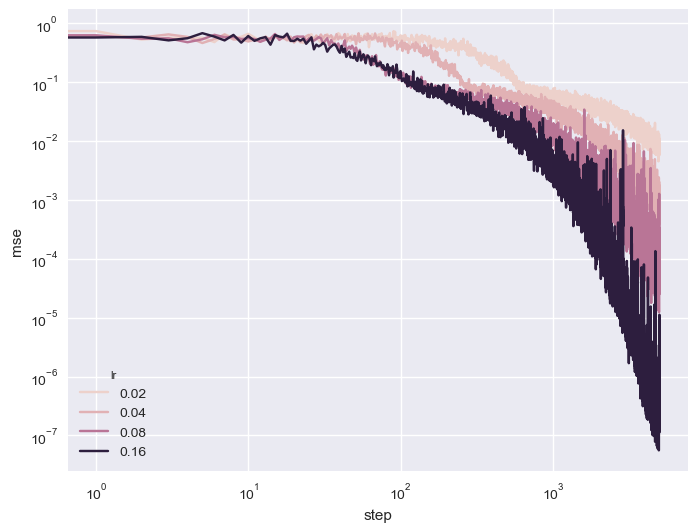

In [23]:
df_lr = pd.DataFrame(losses_train)
df_lr['step'] = range(len(df_lr))

df_lr = df_lr.melt(id_vars='step', value_vars=values_lr, value_name='mse', var_name='lr')\

df_lr.head()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
sns.lineplot(data=df_lr, x='step', y='mse', hue='lr', ax=ax)

#### Report for Problem 2.c.

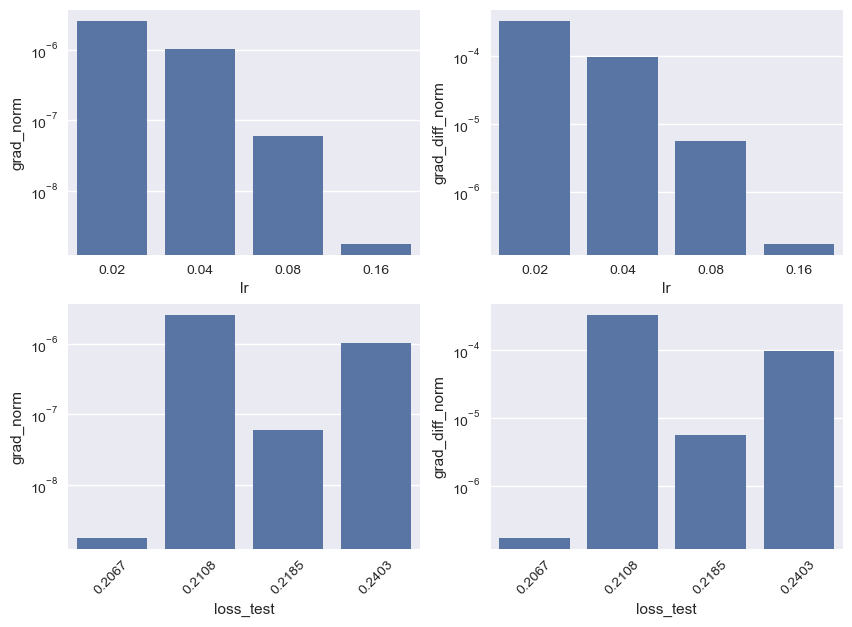

In [24]:
losses_test_lastepoch = []

for lr in values_lr:
    losses_test_lastepoch.append(losses_test[lr][-1])

df_result = pd.DataFrame({
    'lr': values_lr,
    'grad_norm': grads_norm,
    'grad_diff_norm': grads_diff_norm,
    'loss_test': losses_test_lastepoch
})
df_result['loss_test'] = df_result['loss_test'].round(4)

fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(221)
sns.barplot(data=df_result, x='lr', y='grad_norm', ax=ax)
ax.set_yscale('log')
ax = fig.add_subplot(222)
sns.barplot(data=df_result, x='lr', y='grad_diff_norm', ax=ax)
ax.set_yscale('log')
ax = fig.add_subplot(223)
sns.barplot(data=df_result, x='loss_test', y='grad_norm', ax=ax)
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation = 45)
ax = fig.add_subplot(224)
sns.barplot(data=df_result, x='loss_test', y='grad_diff_norm', ax=ax)
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation = 45)

plt.subplots_adjust(wspace=0.2, hspace=0.2)

#### Report for Problem 2.d.

In [25]:
df_loss = pd.DataFrame.from_records(losses)
df_loss.head()

,batch_size,M,lr,weight_decay,loss_train,loss_test
0,10,50,0.08,0.1,0.534563,0.573169
1,10,50,0.08,0.1,0.475855,0.572756
2,10,50,0.08,0.1,0.653891,0.572675
3,10,50,0.08,0.1,0.644518,0.572438
4,10,50,0.08,0.1,0.589606,0.572375


In [26]:
df_loss.sort_values('loss_test', ascending=True).iloc[0]

batch_size       20.000000
M               120.000000
lr                0.080000
weight_decay      0.001000
loss_train        0.053883
loss_test         0.113636
Name: 18108, dtype: float64